## E3.3: Exercise: Improved Solar Radiation Modelling

Using the material above and the global albedo datasets from the main class material, **calculate an improved estimate of the total absorbed power per unit area per month (MJ per m^2 per month) for the Earth land surface**.

You should do this with a function that will take as input the year and returns the monthly total absorbed power density (MJ m^-2 per month) and the monthly total power density (MJ m^-2 per month). 

You might have an optional argument `minute_step` to control the resolution of the calculation as above.

You could then use this to derive latitudinal variations in annual and latitudinal total absorbed power per unit area.

## AE3.3 Answer: Improved Solar Radiation Modelling

The function definition should look something like:

In [1]:
def absorbed_power_density(year,minute_step=60):
    '''Function to calculate the monthly total absorbed solar radiation
        power density in MJ / m^2 for a given year
        given an input dataset albedo and associated lat and lon
        information (in degrees).
        
        The shape of the albedo dataset is: (12,nlat,nlon)
        
        Aguments:
        
        year  : integer of the year
        
        Options:
        
        minute_step : integer: resolution of steps in minutes. Must be
                      a divisor of 60 (e.g. 10, 15, 30, 60)

    '''


The first thing to do is sort out the `lat` and `lon` arrays to be the same shape as `albedo`.

Before that, we'd better read in the `albedo`, `lat` and `lon` datasets here though:

In [2]:
import sys
sys.path.insert(0,'files/python')
# modification of masked.py
from masked2 import masked
import numpy as np

year = 2010

data = masked(dataset=['lat','lon','BHR_SW'],year=year)


In [3]:
# take the first lat and lon only as they are all the same
lat = data['lat'][0]
lon = data['lon'][0]
albedo = data['BHR_SW']
s = albedo.shape
print s

(12, 360, 720)


In [4]:
# pad out the lat and lon arrays
# this is a bit tricky so test this in parts
# we dont need this repeated for each month though
lat2 = np.array([lat] * s[2]).T
lon2 = np.array([lon] * s[1])

In [5]:
print lat2.shape
print lon2.shape

(360, 720)
(360, 720)


Now put together the code for solar radiation modelling for a given lat/lon

In [6]:
import Pysolar
from datetime import datetime

def solar(year, month, day, hour, lat_deg, lon_deg, minute=0, second=0):
    '''Return solar zenith and clear sky radiation
       for given lat, lon and time/date
    '''
    from datetime import datetime
    import Pysolar
    
    d = datetime(year, month, day, hour, minute, second) 
    altitude_deg = Pysolar.GetAltitude(lat_deg, lon_deg, d)
    # W m^-2
    solar_rad = Pysolar.solar.radiation.GetRadiationDirect(d, altitude_deg)
    return 90. - altitude_deg,solar_rad

def radiation(year, month, day, lat, lon,minute_step=30):
    rad = []
    for hour in xrange(24):
        for minute in xrange(0,60,minute_step):
            thr = hour + minute/60.
            # append data line as tuple
            rad.append((thr,) + \
                     solar(year, month, day, hour, lat, lon, minute=minute) +\
                     (month, day, lat, lon))
    # convert to numpy array
    # transpose so access eg zenith as 
    # rad[0]
    rad = np.array(rad).T
    return rad

def days_in_month(month,year=2013):
    ''' number of days in month'''
    import calendar
    return calendar.monthrange(year,month)[1]


In [7]:
# UCL lat/lon
lat = 51.5248
lon = -0.1336

year = 2013

pd = []
for month in xrange(12):
    pd_month = []
    ndays = days_in_month(month+1,year=year)
    print month,ndays
    for day in xrange(ndays):
        rad = radiation(year, month+1, day+1, lat, lon)
        pd_month.append([rad[2].sum() * 60 * 30])
    pd_month = np.array(pd_month).T
    pd.append([month,pd_month.sum()])
pd = np.array(pd).T

0 31
1 28
2 31
3 30
4 31
5 30
6 31
7 31
8 30
9 31
10 30
11 31


Putiing that all together now:

In [8]:
# functions so far

import sys
sys.path.insert(0,'files/python')
# modification of masked.py
from masked2 import masked
import numpy as np
import Pysolar
from datetime import datetime

def solar(year, month, day, hour, lat_deg, lon_deg, minute=0, second=0):
    '''Return solar zenith and clear sky radiation
       for given lat, lon and time/date
    '''
    from datetime import datetime
    import Pysolar
    
    d = datetime(year, month, day, hour, minute, second) 
    altitude_deg = Pysolar.GetAltitude(lat_deg, lon_deg, d)
    # W m^-2
    solar_rad = Pysolar.solar.radiation.GetRadiationDirect(d, altitude_deg)
    return 90. - altitude_deg,solar_rad

def radiation(year, month, day, lat, lon,minute_step=30):
    rad = []
    for hour in xrange(24):
        for minute in xrange(0,60,minute_step):
            thr = hour + minute/60.
            # append data line as tuple
            rad.append((thr,) + \
                     solar(year, month, day, hour, lat, lon, minute=minute) +\
                     (month, day, lat, lon))
    # convert to numpy array
    # transpose so access eg zenith as 
    # rad[0]
    rad = np.array(rad).T
    return rad

def days_in_month(month,year=2013):
    ''' number of days in month'''
    import calendar
    return calendar.monthrange(year,month)[1]



Before proceeding, let us examine the variation in total monthly power density with latitude.

With the model developed in the main notes, we would expect no varition with longitude (it was a function of latitude only).

In this more precise model, we would expect only small variation,  but we should examine this:

In [9]:
'''
Processing -- test for several lat/long
'''

import numpy.ma as ma

year = 2010

minute_step = 60

data = masked(dataset=['lat','lon','BHR_SW'],year=year)

lat = data['lat'][0]
lon = data['lon'][0]
albedo = data['BHR_SW']
s = albedo.shape
lat = ma.array( [lat] *s[2]).T
lon = ma.array([lon] * s[1])

# array for output
absorbed = ma.array(np.zeros_like(albedo),mask=albedo.mask)
# 

#for i in xrange(lat.shape[0]):
#    for j in xrange(lat.shape[1]):

# try it out for 6 samples in longitude, including first and last
lons = range(0,lon.shape[1],lon.shape[1]/5) + [lon.shape[1]-1]

# an array to hold the sample pd for the sample
# longitudes
all_pd = []

i = lon.shape[0]/2
for j in lons:
    pd = []
    # loop over month
    for month in xrange(12):
        pd_month = []
        ndays = days_in_month(month+1,year=year)
        print i,j,month,ndays
        # loop over days
        for day in xrange(ndays):
            # solar radiation for that day
            rad = radiation(year, month+1, day+1, \
                            lat[i,j], lon[i,j],minute_step=minute_step)
            pd_month.append([rad[2].sum() * 60 * minute_step])
        pd_month = np.array(pd_month).T
        pd.append([pd_month.sum()])
    # pd is the power density for each month
    all_pd.append(pd)
    
# MJ per m2
all_pd = np.array(all_pd).squeeze()


180 0 0 31
180 0 1 28
180 0 2 31
180 0 3 30
180 0 4 31
180 0 5 30
180 0 6 31
180 0 7 31
180 0 8 30
180 0 9 31
180 0 10 30
180 0 11 31
180 144 0 31
180 144 1 28
180 144 2 31
180 144 3 30
180 144 4 31
180 144 5 30
180 144 6 31
180 144 7 31
180 144 8 30
180 144 9 31
180 144 10 30
180 144 11 31
180 288 0 31
180 288 1 28
180 288 2 31
180 288 3 30
180 288 4 31
180 288 5 30
180 288 6 31
180 288 7 31
180 288 8 30
180 288 9 31
180 288 10 30
180 288 11 31
180 432 0 31
180 432 1 28
180 432 2 31
180 432 3 30
180 432 4 31
180 432 5 30
180 432 6 31
180 432 7 31
180 432 8 30
180 432 9 31
180 432 10 30
180 432 11 31
180 576 0 31
180 576 1 28
180 576 2 31
180 576 3 30
180 576 4 31
180 576 5 30
180 576 6 31
180 576 7 31
180 576 8 30
180 576 9 31
180 576 10 30
180 576 11 31
180 719 0 31
180 719 1 28
180 719 2 31
180 719 3 30
180 719 4 31
180 719 5 30
180 719 6 31
180 719 7 31
180 719 8 30
180 719 9 31
180 719 10 30
180 719 11 31


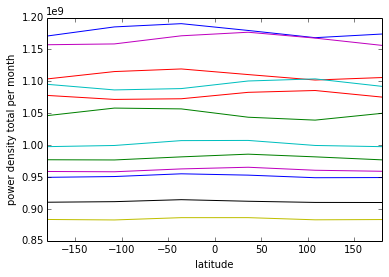

In [10]:
import pylab as plt
plt.plot(lon[0,lons],all_pd)
plt.xlim(-180.,180.)
plt.xlabel('latitude')
plt.ylabel('power density total per month')

So, with this in mind, let's just take a single value per latitude as otherwise the processing cost will be rather high.

Putting this into a function (in this case, reading the albedo, lat and long internally):

In [17]:
def absorbed_power_density(year,minute_step=60):
    '''Function to calculate the monthly total absorbed solar radiation
        power density in MJ / m^2 for a given year
        given an input dataset albedo and associated lat and lon
        information (in degrees).
        
        The shape of the albedo dataset is: (12,nlat,nlon)
        
        Aguments:
        
        year  : integer of the year
        
        Options:
        
        minute_step : integer: resolution of steps in minutes. Must be
                      a divisor of 60 (e.g. 10, 15, 30, 60)

    '''

    data = masked(dataset=['lat','lon','BHR_SW'],year=year)
    
    lat = data['lat'][0]
    lon = data['lon'][0]
    albedo = data['BHR_SW']
    s = albedo.shape
    lat = ma.array( [lat] *s[2]).T
    lon = ma.array([lon] * s[1])
    
    # array for output
    absorbed = ma.array(np.zeros_like(albedo),mask=albedo.mask)
    power_density = ma.array(np.zeros_like(albedo),mask=albedo.mask)
    # 
    
    for i in xrange(0,lat.shape[0]):
        print 'lat',lat[i,0]
        # single longitude
        for j in [lat.shape[1]/2]:
            pd = []
            # loop over month
            for month in xrange(12):
                pd_month = []
                ndays = days_in_month(month+1,year=year)
                # loop over days
                for day in xrange(ndays):
                    # solar radiation for that day
                    rad = radiation(year, month+1, day+1, \
                                    lat[i,j], lon[i,j],minute_step=minute_step)
                    # get rid of -ves 
                    rad[rad<0] = 0
                    pd_month.append([rad[2].sum() * 60 * minute_step])
                pd_month = np.array(pd_month).T
                pd.append([pd_month.sum()])
            pd = np.array(pd).squeeze().T
            
            # pd is the power density for each month
            # load this into all longitudes
            for k in xrange(power_density.shape[0]):
                power_density[k,i,:] = pd[k]
    power_density /= 10.**6 # MJ per m2
    absorbed = power_density * (1 - albedo) 
    return absorbed,power_density

In [18]:
# this will still take some minutes to calculate
absorbed,power_density = absorbed_power_density(year,minute_step=60)

lat 89.6957
lat 89.196
lat 88.6963
lat 88.1966
lat 87.6969
lat 87.1972
lat 86.6975
lat 86.1978
lat 85.6981
lat 85.1984
lat 84.6987
lat 84.1991
lat 83.6994
lat 83.1997
lat 82.7
lat 82.2003
lat 81.7006
lat 81.2009
lat 80.7012
lat 80.2015
lat 79.7018
lat 79.2021
lat 78.7024
lat 78.2027
lat 77.703
lat 77.2033
lat 76.7036
lat 76.2039
lat 75.7042
lat 75.2045
lat 74.7048
lat 74.2051
lat 73.7054
lat 73.2057
lat 72.706
lat 72.2063
lat 71.7066
lat 71.2069
lat 70.7072
lat 70.2075
lat 69.7078
lat 69.2081
lat 68.7084
lat 68.2087
lat 67.709
lat 67.2093
lat 66.7096
lat 66.2099
lat 65.7102
lat 65.2105
lat 64.7108
lat 64.2111
lat 63.7114
lat 63.2118
lat 62.7121
lat 62.2124
lat 61.7127
lat 61.213
lat 60.7133
lat 60.2136
lat 59.7139
lat 59.2142
lat 58.7145
lat 58.2148
lat 57.7151
lat 57.2154
lat 56.7157
lat 56.216
lat 55.7163
lat 55.2166
lat 54.7169
lat 54.2172
lat 53.7175
lat 53.2178
lat 52.7181
lat 52.2184
lat 51.7187
lat 51.219
lat 50.7193
lat 50.2196
lat 49.7199
lat 49.2202
lat 48.7205
lat 48.2208
la

In [19]:
# this is how you can save a numpy array
np.savez('files/data/absorbed.npz',absorbed=np.array(absorbed),\
         power_density=np.array(power_density),mask=absorbed.mask)

In [20]:
# now next time we should be able to load it
try:
    f = np.load('files/data/absorbed.npz')
    mask = f['mask']
    absorbed,power_density = ma.array(f['absorbed'],mask=mask),\
                             ma.array(f['power_density'],mask=mask)
except:
    absorbed,power_density = absorbed_power_density(year,minute_step=60)

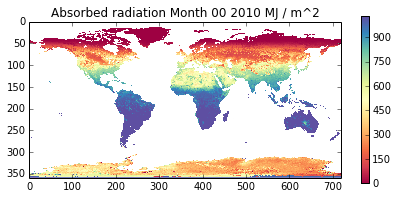

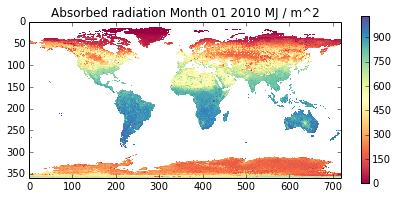

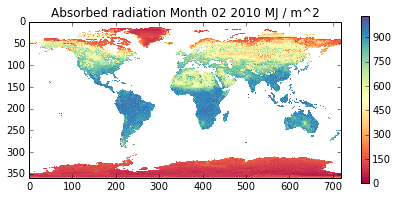

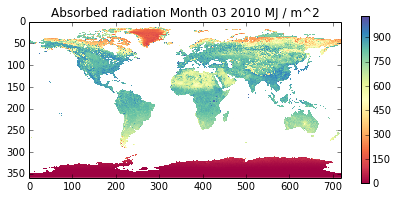

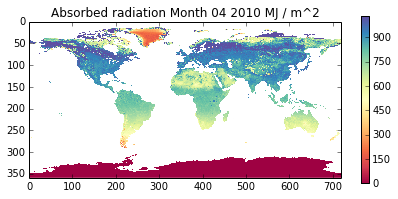

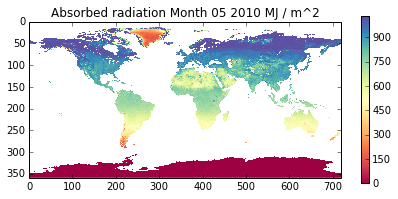

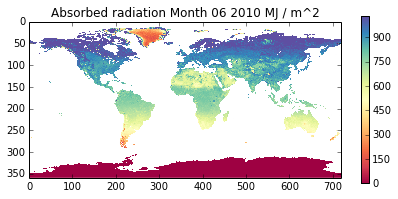

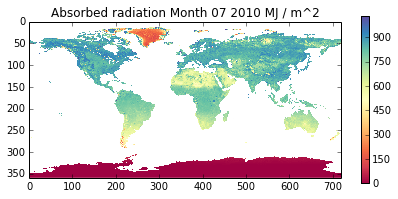

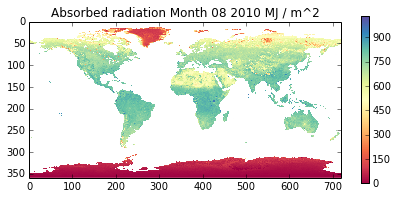

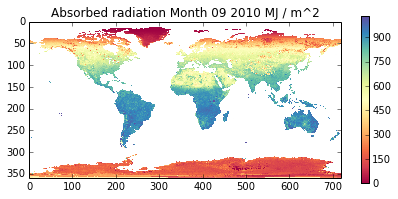

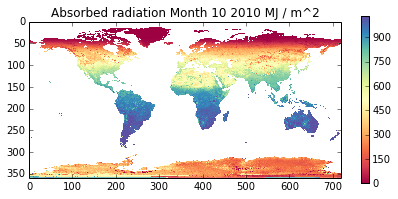

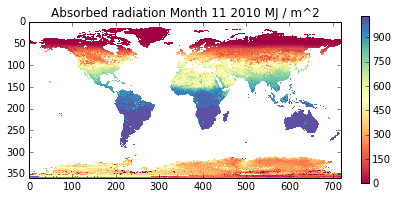

In [29]:
import pylab as plt

cmap = plt.get_cmap('Spectral')
vmax = absorbed.max()/2
vmin = 0.

for m in xrange(12):
    plt.figure(figsize=(7,3))
    plt.title('Absorbed radiation Month %02d %d MJ / m^2'%(m,year))
    plt.imshow(absorbed[m],cmap=cmap,interpolation='none',vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.savefig('files/data/absorbed%02d.jpg'%m)

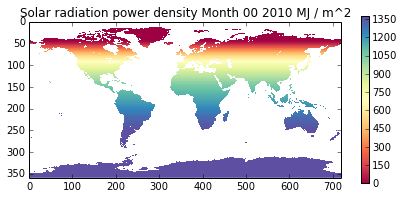

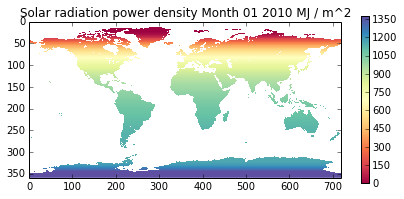

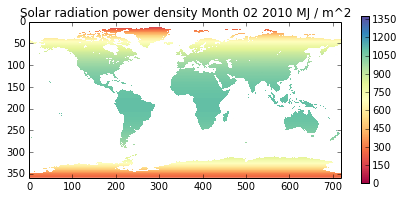

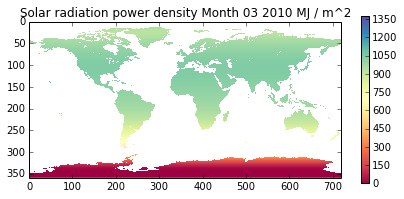

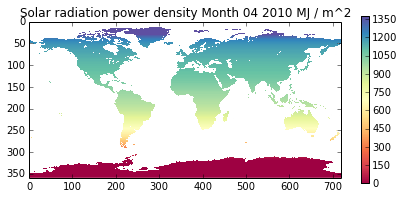

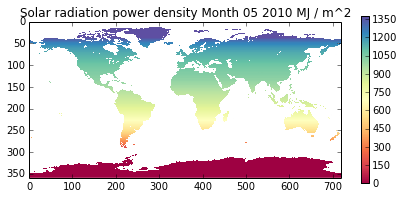

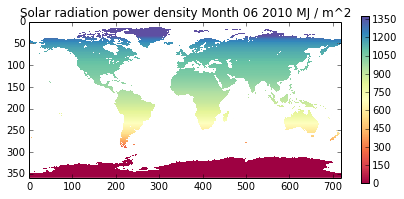

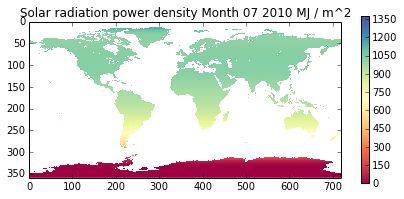

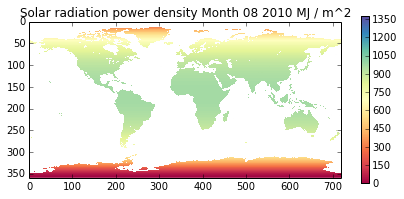

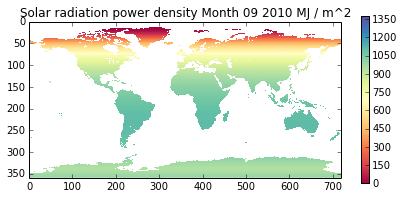

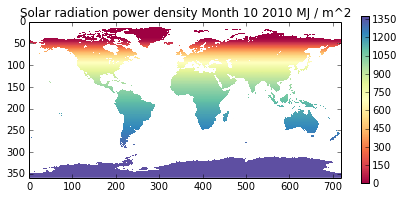

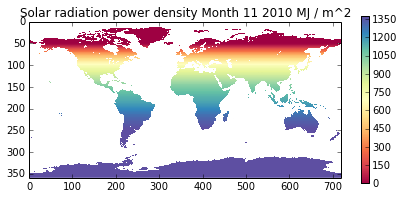

In [30]:
import pylab as plt

cmap = plt.get_cmap('Spectral')
vmax = absorbed.max() * 2./3.
vmin = 0.

for m in xrange(12):
    plt.figure(figsize=(7,3))
    plt.title('Solar radiation power density Month %02d %d MJ / m^2'%(m,year))
    plt.imshow(power_density[m],cmap=cmap,interpolation='none',vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.savefig('files/data/power%02d.jpg'%m)

In [2]:
# make some movies!???
import os

for t in ['power','absorbed']:
    for m in xrange(12):
        cmd = 'convert files/data/%s%02d.jpg files/data/%s%02d.gif'%(t,m,t,m)
        print cmd
        os.system(cmd)
        
    cmd = "convert -delay 100  -loop 0  \
            files/data/%s??.gif files/data/%s_movie.gif"%(t,t)
    os.system(cmd)

convert files/data/power00.jpg files/data/power00.gif
convert files/data/power01.jpg files/data/power01.gif
convert files/data/power02.jpg files/data/power02.gif
convert files/data/power03.jpg files/data/power03.gif
convert files/data/power04.jpg files/data/power04.gif
convert files/data/power05.jpg files/data/power05.gif
convert files/data/power06.jpg files/data/power06.gif
convert files/data/power07.jpg files/data/power07.gif
convert files/data/power08.jpg files/data/power08.gif
convert files/data/power09.jpg files/data/power09.gif
convert files/data/power10.jpg files/data/power10.gif
convert files/data/power11.jpg files/data/power11.gif
convert files/data/absorbed00.jpg files/data/absorbed00.gif
convert files/data/absorbed01.jpg files/data/absorbed01.gif
convert files/data/absorbed02.jpg files/data/absorbed02.gif
convert files/data/absorbed03.jpg files/data/absorbed03.gif
convert files/data/absorbed04.jpg files/data/absorbed04.gif
convert files/data/absorbed05.jpg files/data/absorbe

![](files/data/power_movie.gif)
![](files/data/absorbed_movie.gif)

This code is still quite slow (even for a single longitude).

You should look it over and see how you might make it more efficient.

Some ideas:

- interpolate the radiation field (over latitude?) and possibly improve by sub sampling over longitude and interpolating that as well
- when calculating daily integrals, don't start the calculations until the sun is above the horizon (and the same for sunset).

The exercise asks you to perform summations over latitude. This should be simple enough, being of the form:

    absorbed.sum(axis=(0,2))

which will sum over axes 0 (month) and 2 (longitude).

Total absorbed involves working out the area for each sample pixel and including that in teh calculation. That is left as an exercise here.